In [2]:
# Import packages for data analysis
import numpy as np   
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os   
from utils_exploration import GeoTsObject
import plotly.express as px
import plotly.graph_objects as go
import plotly as py
import statsmodels.api as sm
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units


In [3]:
geo_ts = GeoTsObject()

In [4]:
tair_ds = xr.open_mfdataset(geo_ts.tair_path)
rainf_ds = xr.open_mfdataset(geo_ts.rainf_path)
snowf_ds = xr.open_mfdataset(geo_ts.snowf_path)
qair_ds = xr.open_mfdataset(geo_ts.qair_path)
swdown_ds = xr.open_mfdataset(geo_ts.swdown_path)
psurf_ds = xr.open_mfdataset(geo_ts.psurf_path)
wind_ds = xr.open_mfdataset(geo_ts.wind_path)

In [5]:
min_lon = 84
max_lon = 88
min_lat = 27
max_lat = 29

In [6]:
# Subset the data to the region of interest
def subset(ds, min_lon, max_lon, min_lat, max_lat):
    ds = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
    return ds

In [7]:
tair_subset = subset(tair_ds, min_lon, max_lon, min_lat, max_lat)
rainf_subset = subset(rainf_ds, min_lon, max_lon, min_lat, max_lat)
snowf_subset = subset(snowf_ds, min_lon, max_lon, min_lat, max_lat)
qair_subset = subset(qair_ds, min_lon, max_lon, min_lat, max_lat)
swdown_subset = subset(swdown_ds, min_lon, max_lon, min_lat, max_lat)
psurf_subset = subset(psurf_ds, min_lon, max_lon, min_lat, max_lat)
wind_subset = subset(wind_ds, min_lon, max_lon, min_lat, max_lat)


In [8]:
# Make a new dataset for precipitation which is the sum of rain and snow times 3600 to convert to mm/hr
# Assign the new variable precip and add it to the dataset, give the units of mm/hr
def precip_ds(rainf, snowf):
    precip = rainf.Rainf + snowf.Snowf
    precip = precip * 3600
    precip.attrs['units'] = 'mm/hr'
    return precip

In [9]:
precip_subset = precip_ds(rainf_subset, snowf_subset)

In [10]:
# Convert temperature dataset to temperature in degrees Celsius and give the units of degC
def degc_ds(tair):
    degc = tair.Tair - 273.15
    degc.attrs['units'] = 'degC'
    return degc

In [11]:
temp_subset = degc_ds(tair_subset)

In [12]:
# Convert snowfall dataset to snowfall in mm/hr and give the units of mm/hr
def snowf_hour(snowf):
    snowf = snowf.Snowf * 3600
    snowf.attrs['units'] = 'mm/hr'
    return snowf

In [13]:
snowf_subset = snowf_hour(snowf_subset)

In [14]:
# Convert rainfall dataset to rainfall in mm/hr and give the units of mm/hr
def rainf_hour(rainf):
    rainf = rainf.Rainf * 3600
    rainf.attrs['units'] = 'mm/hr'
    return rainf

In [15]:
rainf_subset = rainf_hour(rainf_subset)

In [16]:
# Make a new dataset where presure is converted to hPa and give the units of hPa

def hpa_ds(psurf):
    hpa = psurf.PSurf / 100
    hpa.attrs['units'] = 'hPa'
    return hpa

In [17]:
hpa_subset = hpa_ds(psurf_subset)

In [18]:
# Make a new dataset where specific humidity is converted to relative humidity and give the units of %
# Use the MetPy function to calculate relative humidity

def rel_hum_ds(psurf, temp, qair):
    rh = relative_humidity_from_specific_humidity(psurf.values * units.hPa, temp.values * units.degC, qair.Qair.values).to('percent').magnitude
    rh = rh * 0.01
    return rh

In [19]:
rel_hum = rel_hum_ds(hpa_subset, temp_subset, qair_subset)

In [20]:
rel_hum_subset = xr.Dataset({'RH': (['time', 'lat', 'lon'], rel_hum)}, 
                        coords={'time': tair_subset.time, 'lat': tair_subset.lat, 'lon': tair_subset.lon})

In [9]:
# Make a make map plot of the temperature data with mean temperature for each grid cell
def mean_plot(ds):
    ds.mean(dim='time').plot()
    plt.show()

In [106]:
# Make a snow depth dataset where the snowpack resets to 0 at October 1st and 
# the snowpack accumulates until September 30th next year
# Each year the snowpack accumulates from October 1st to September 30th of the next year before resetting to 0

def snowpack_ds(snowf):
    snowpack = snowf.Snowf
    snowpack = snowpack * 3600
    snowpack = snowpack.resample(time='AS-OCT').sum(dim='time')
    return snowpack

In [107]:
snowpack_ds = snowpack_ds(snowf_subset)

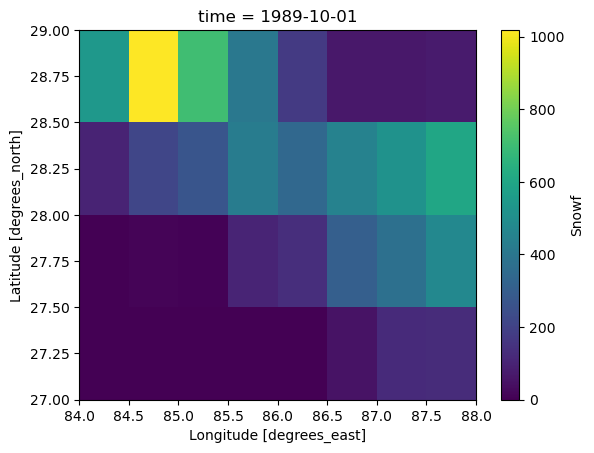

In [108]:
snowpack_ds.isel(time=0).plot()

In [109]:
# Make a timeseries  plot of the snowpack data for the region of interest
def snowpack_plot(ds):
    ds.mean(dim=['lat', 'lon']).plot()
    plt.show()

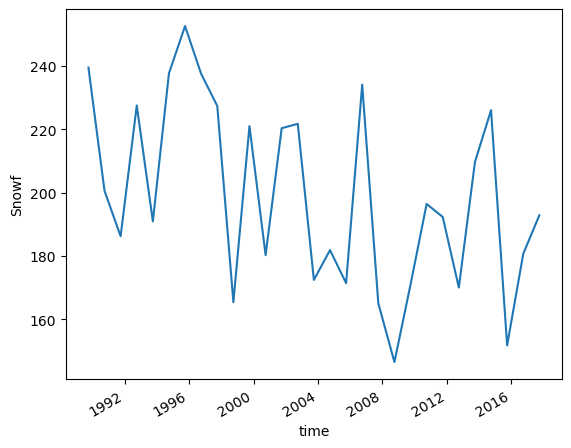

In [111]:
snowpack_plot(snowpack_ds[:-2])

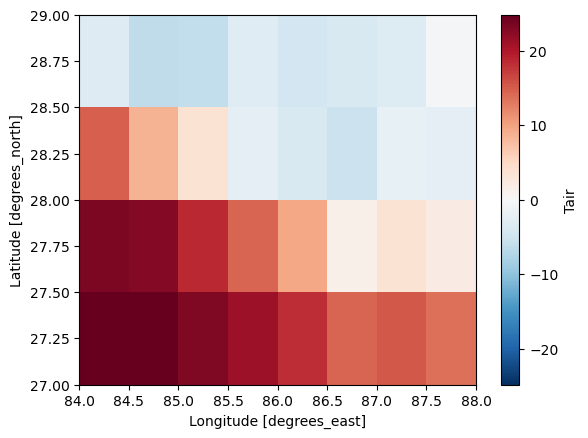

In [10]:
mean_plot(temp_ds)

In [11]:
# Make a histogram of the dataset
def hist(ds, bins = 50):
    ds.plot.hist(bins=bins)
    plt.show()

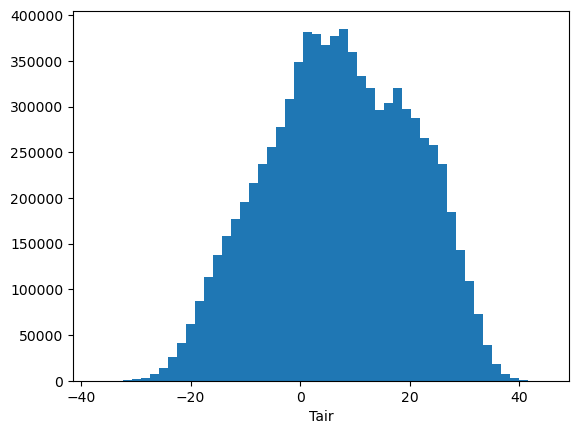

In [12]:
hist(temp_ds)

In [13]:
# Get mean dataset over time
def mean_dataset(ds):
    return ds.mean(dim='time')

In [16]:
temp_ds_mean = mean_dataset(temp_ds)

In [17]:
# Get timeseries from a specific grid cell
def get_timeseries_point(ds, lon, lat):
    return ds.sel(lon=lon, lat=lat)

In [18]:
# Get mean timeseries from the whole region
def get_mean_timeseries(ds):
    return ds.mean(dim=['lon', 'lat'])

In [19]:
temp_mean_timeseries = get_mean_timeseries(temp_ds)

In [26]:
# Resample the timeseries to monthly data
def resample_monthly(ds):
    return ds.resample(time='M').mean()

In [34]:
monthly_mean_temp = resample_monthly(temp_mean_timeseries)

In [28]:
# Plot timeseries with an interactive date range slider from plotly
def plot_timeseries(ds):
    fig = px.line(ds, x=ds.time, y=ds.values)
    fig.show()

In [30]:
plot_timeseries(monthly_mean_temp)

In [40]:
# Make timeseries to a pandas dataframe
def ts_to_df(ds):
    return ds.to_dataframe()

In [121]:
temp_ts_mean_df = ts_to_df(monthly_mean_temp)

In [44]:
# Analyze the timeseries for stationarity
def stationary( ts, window=12, cutoff=0.01):
    #Determing rolling statistics
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.stattools.adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dfoutput['p-value'] < cutoff:
        print('The series is likely stationary.')
    else:
        print('The series is likely non-stationary.')

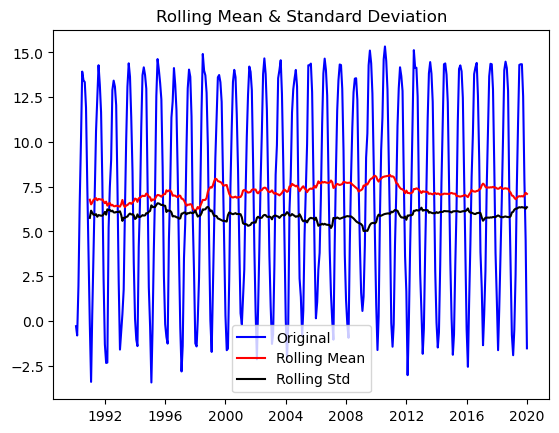

Results of Dickey-Fuller Test:
Test Statistic                  -2.878254
p-value                          0.047936
#Lags Used                      15.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64
The series is likely non-stationary.


In [45]:
stationary(temp_ts_mean_df)

In [115]:
snowpack_ts = get_mean_timeseries(snowpack_ds)[:-2]

In [117]:
snowpack_ts_mean_df = ts_to_df(snowpack_ts)

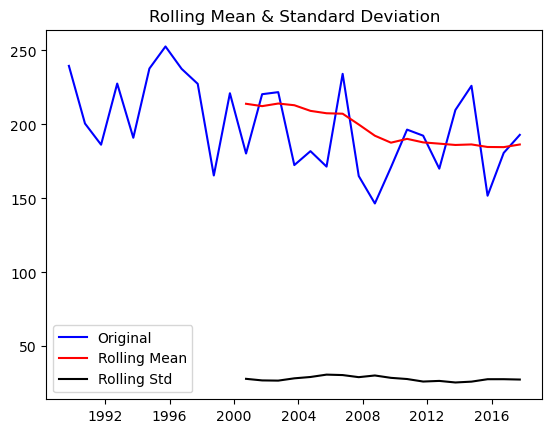

Results of Dickey-Fuller Test:
Test Statistic                 -1.615507
p-value                         0.475086
#Lags Used                      9.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64
The series is likely non-stationary.


In [118]:
stationary(snowpack_ts_mean_df)

In [127]:
# Remove seasonality from the dataframe timeseries
def remove_seasonality(ds):
    return ds - ds.rolling(12).mean()

In [136]:
#remove nans from dataframe
def remove_nans(ds):
    return ds.dropna()

In [137]:
temp_ts_mean_df = remove_nans(temp_ts_mean_df)

In [ ]:
# Variables:
# precip_subset
# temp_subset
# swdown_subset
# wind_subset
# hpa_subset
# rel_hum_subset
# snowf_subset
# rainf_subset

In [149]:
# Make a pandas dataframe of all the subsetted variables
def make_df(precip, temp, swdown, wind, hpa, rh, snowf, rainf):
    df = pd.DataFrame({'Precipitation': precip, 'Temperature': temp, 'Shortwave Down': swdown, 'Wind': wind, 'Pressure': hpa, 'Relative Humidity': rh, 'Snowfall': snowf, 'Rainfall': rainf})
    return df

In [184]:
precip_mean_ts = precip_subset.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])
temp_mean_ts = temp_subset.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])
swdown_mean_ts = swdown_subset.sel(time= slice('2000','2015')).SWdown.mean(dim=['lat', 'lon'])
wind_mean_ts = wind_subset.Wind.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])
hpa_mean_ts = hpa_subset.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])
rel_hum_mean_ts = rel_hum_subset.sel(time= slice('2000','2015')).RH.mean(dim=['lat', 'lon'])
snowf_mean_ts = snowf_subset.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])
rainf_mean_ts = rainf_subset.sel(time= slice('2000','2015')).mean(dim=['lat', 'lon'])


In [185]:
subset_df = make_df(precip_mean_ts.values, temp_mean_ts.values, swdown_mean_ts.values, 
                    wind_mean_ts.values, hpa_mean_ts.values, rel_hum_mean_ts.values, 
                    snowf_mean_ts.values, rainf_mean_ts.values)

In [188]:
# Write a script that make a correlation matrix plot of the variables
def correlation_matrix(df):
    corr = df.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)
    plt.show()

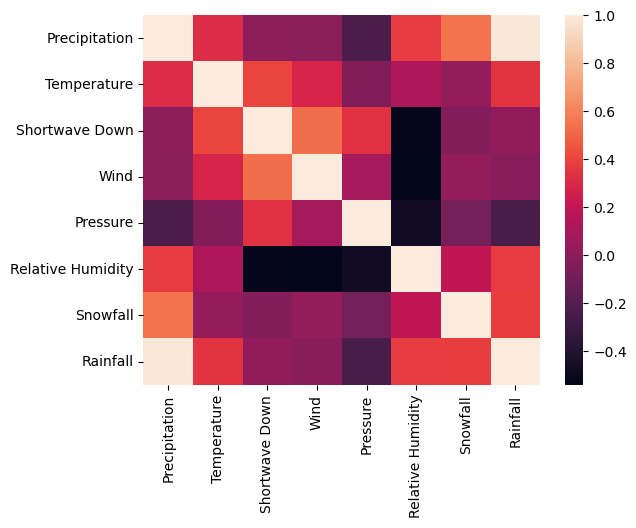

In [189]:
correlation_matrix(subset_df)

In [190]:
subset_df.describe()

,Precipitation,Temperature,Shortwave Down,Wind,Pressure,Relative Humidity,Snowfall,Rainfall
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,0.169983,7.420062,218.660950,1.313083,711.862305,0.711383,0.021702,0.148282
std,0.381983,7.386541,287.822449,0.441958,2.831892,0.137362,0.076538,0.346361
min,0.000000,-14.826475,0.000000,0.467250,701.554504,0.145655,0.000000,0.000000
25%,0.000000,2.042475,0.000000,1.006456,709.847656,0.612740,0.000000,0.000000
50%,0.005646,8.765178,11.928855,1.199816,711.761932,0.721016,0.000000,0.000384
75%,0.153420,12.929329,441.579857,1.515281,713.790482,0.822002,0.009867,0.119258
max,6.407076,23.817724,1078.565796,3.826096,723.168457,0.975493,1.842137,5.341466


In [192]:
# Make a scatter_matrix plot of the variables
def scatter_matrix(df):
    pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(10, 10))
    plt.show()

In [193]:
# Analyze subset_df for interesting statistical properties
# Make a plot of some of the statistics
def analyze_df(df):
    df.hist()
    plt.show()
    
    df.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
    plt.show()
    
    df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
    plt.show()
    
    scatter_matrix(df)
    plt.show()

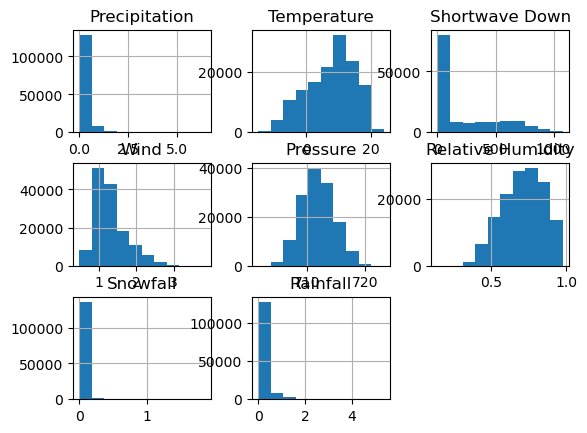

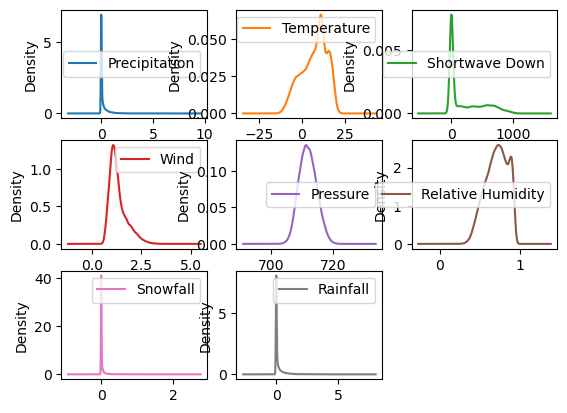

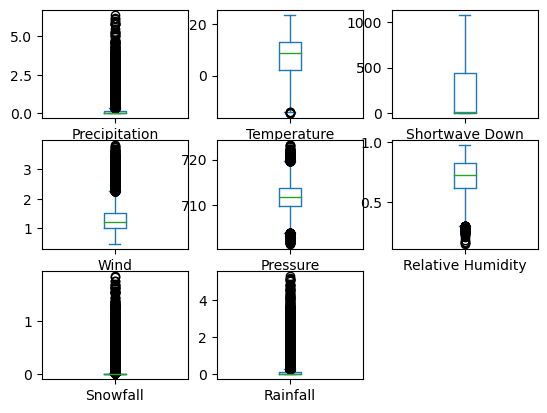

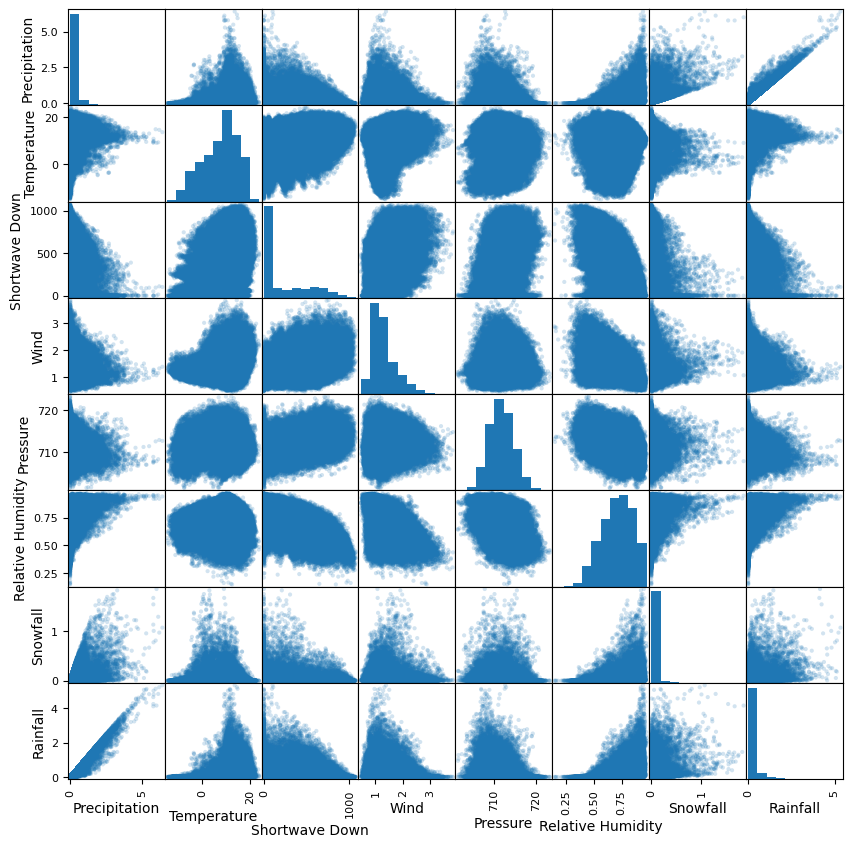

In [194]:
analyze_df(subset_df)

In [27]:
# Make a high resolution temperature map of the region showing country borders
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def temp_map(ds):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ds.plot(ax=ax, transform=ccrs.PlateCarree())
    plt.show()

In [51]:
# Make another temperature map that has higher resolution, based on Krige interpolation
def temp_map_krige(ds):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=30)
    plt.show()

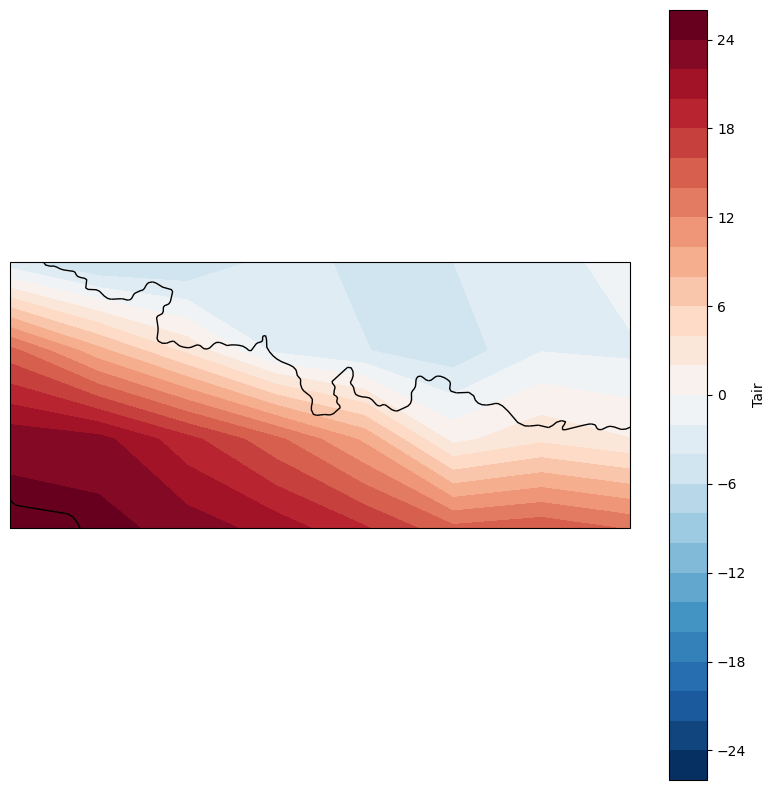

In [53]:
temp_map_krige(temp_subset.mean(dim='time'))

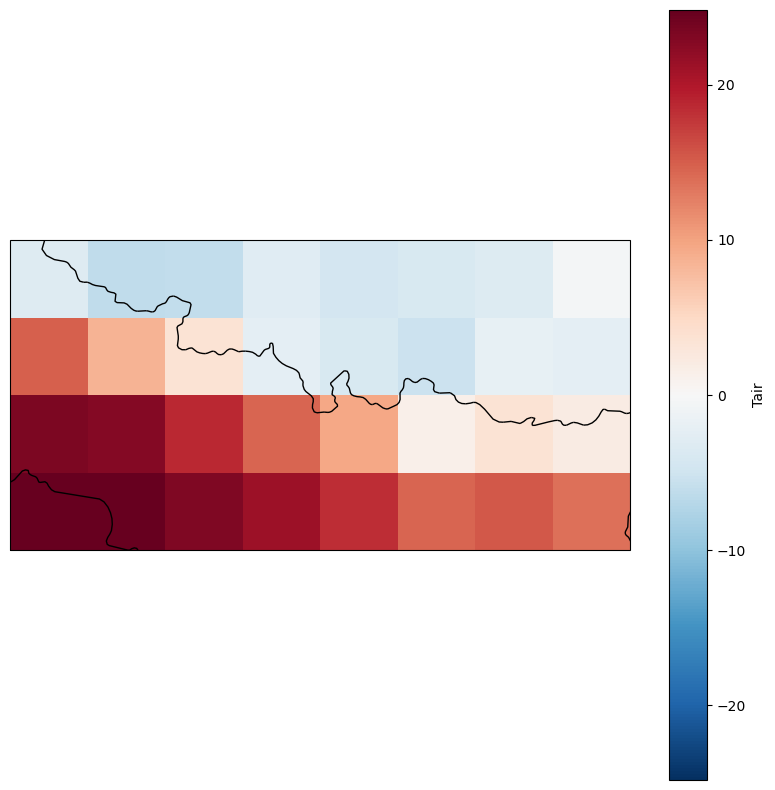

In [29]:
temp_map(temp_subset.mean(dim='time'))